<a href="https://colab.research.google.com/github/sindhu213/Pytorch/blob/main/NLP/seq2seq_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task: Translate from English to Hindi

In [3]:
import re
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator

## Text Preprocessing

In [4]:
root_dir = 'drive/My Drive/assets/hin_eng.txt'

In [5]:
sentences = []
with open(root_dir,'r') as file:
  for line in file: 
    sentences.append(line.split('\t')[:2])

In [6]:
def tokenize_en(text):
  tokenized = re.sub(r'[^\w\s+]',' ',text.lower())
  return tokenized.split()

def tokenize_hi(text):
  tokenized = re.sub(r'[!#$%&()+,-./।:;"<=>?[\]^_`{|}~]',' ',text)
  return tokenized.split()

In [7]:
def yield_tokens(iterable,lang):
  for en,hi in iterable:
    if lang is 'en': yield tokenize_en(en)
    else: yield tokenize_hi(hi)

In [8]:
en_vocab = build_vocab_from_iterator(yield_tokens(sentences,'en'),min_freq=1,specials=["<unk>","<pad>","<bos>","<eos>"])
en_vocab.set_default_index(0)

hi_vocab = build_vocab_from_iterator(yield_tokens(sentences,'hi'),min_freq=1,specials=["<unk>","<pad>","<bos>","<eos>"])
hi_vocab.set_default_index(0)

In [9]:
print("en_vocab size: ",len(en_vocab))
print("hi_vocab size: ",len(hi_vocab))

en_vocab size:  2358
hi_vocab size:  2863


In [10]:
en_pipeline = lambda x: en_vocab(["<bos>",*tokenize_en(x),"<eos>"])
hi_pipeline = lambda x: hi_vocab(["<bos>",*tokenize_hi(x),"<eos>"])

In [23]:
def collate_batch(data_iter):
  src,tgt_data,tgt_label = [],[],[]
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for x,y in data_iter:
    src_encoded = en_pipeline(x)
    src.append(torch.tensor(src_encoded,dtype=torch.int64,device=device))
    tgt_encoded = hi_pipeline(y)
    tgt_data.append(torch.tensor(tgt_encoded[:-1],dtype=torch.int64,device=device))
    tgt_label.append(torch.tensor(tgt_encoded[1:],dtype=torch.int64,device=device))
  
  src = pad_sequence(src,batch_first=True,padding_value=1)
  tgt_data = pad_sequence(tgt_data,batch_first=True,padding_value=1)
  tgt_label = pad_sequence(tgt_label,batch_first=True,padding_value=1)
  
  return src,tgt_data,tgt_label

In [28]:
torch.manual_seed(42)
batch_size = 64

train_dl = DataLoader(sentences,batch_size=batch_size,shuffle=True,collate_fn=collate_batch,drop_last=True)  

## Model Definition

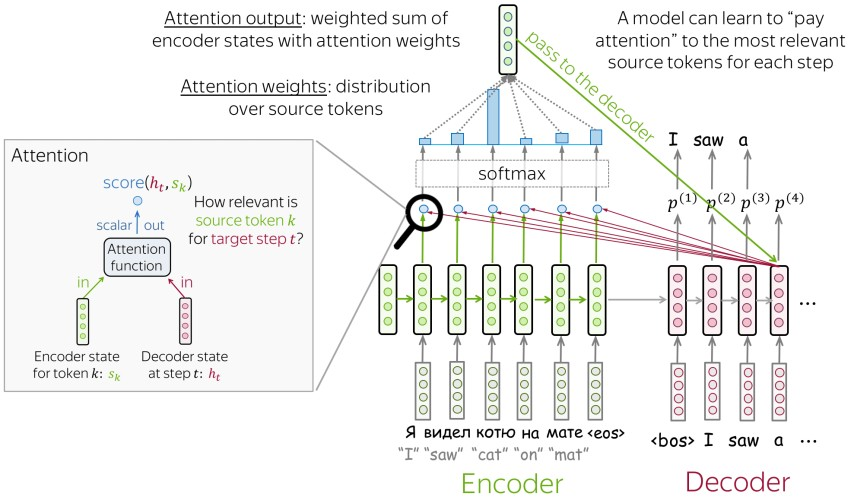

Image Source: [LenaVoitaNLP](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

In [33]:
vocab_size = len(en_vocab)
embed_dim = 1024
rnn_hidden_size = 512

In [32]:
class Encoder(nn.Module):

  def __init__(self):
    super(Encoder,self).__init__(vocab_size,embed_dim,rnn_hidden_size)
    self.embedding = nn.Embedding(vocab_size,embed_dim,padding_idx=1)
    self.lstm = nn.LSTM(embed_dim,rnn_hidden_size,batch_first=True)

  def forward(self,input):
    """
    INPUT: [batch_size,len(english_sentence)]
    IMPLCIT:
      hidden: [1,batch_size,rnn_hidden_size]
      cell: [1,batch_size,rnn_hidden_size]
    OUTPUT:
      hidden: [1,batch_size,rnn_hidden_size]
      cell: [1,batch_size,rnn_hidden_size]
    """
    
    ## out: [batch_size,len(english_sentence),embed_dim]
    out = self.embedding(input)

    ## out: [batch_size,len(english_sentence),rnn_hidden_size]
    ## hidden: [1,batch_size,rnn_hidden_size]
    ## cell: [1,batch_size,rnn_hidden_size]
    out,(hidden,cell) = self.lstm(out)

    return hidden,cell